In [ ]:
!nvidia-smi

Tue Oct  1 16:15:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
HOME

'/content'

# Install YOLOV8

In [ ]:
!pip install ultralytics supervision roboflow

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.2 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 36.5/112.6 GB disk)


In [ ]:
from ultralytics import YOLO

from IPython.display import display , Image

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ROBOFLOW_API_KEY")
project = rf.workspace("mantvy").project("homework-clc68")
version = project.version(3)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to homework-3 in yolov11:: 100%|██████████| 412/412 [00:00<00:00, 3683.47it/s]


# Custom Training

In [ ]:
%cd {HOME}
!yolo task=detect mode=train model=yolo11x.pt data='/content/homework-3/data.yaml' epochs=100 batch=10 imgsz=640 plots=True

/content
WARNING ⚠️ conflicting 'task=segment' passed with 'task=detect' model. Ignoring 'task=segment' and updating to 'task=detect' to match model.
Ultralytics 8.3.2 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11x.pt, data=/content/homework-3/data.yaml, epochs=100, time=None, patience=100, batch=10, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, ret

In [ ]:
!ls {HOME}/runs/detect/train3/

args.yaml					    PR_curve.png	 train_batch1.jpg
confusion_matrix_normalized.png			    R_curve.png		 train_batch2.jpg
confusion_matrix.png				    results.csv		 val_batch0_labels.jpg
events.out.tfevents.1727800933.bec1f58d2348.7450.0  results.png		 val_batch0_pred.jpg
F1_curve.png					    train_batch0.jpg	 val_batch1_labels.jpg
labels_correlogram.jpg				    train_batch1350.jpg  val_batch1_pred.jpg
labels.jpg					    train_batch1351.jpg  weights
P_curve.png					    train_batch1352.jpg


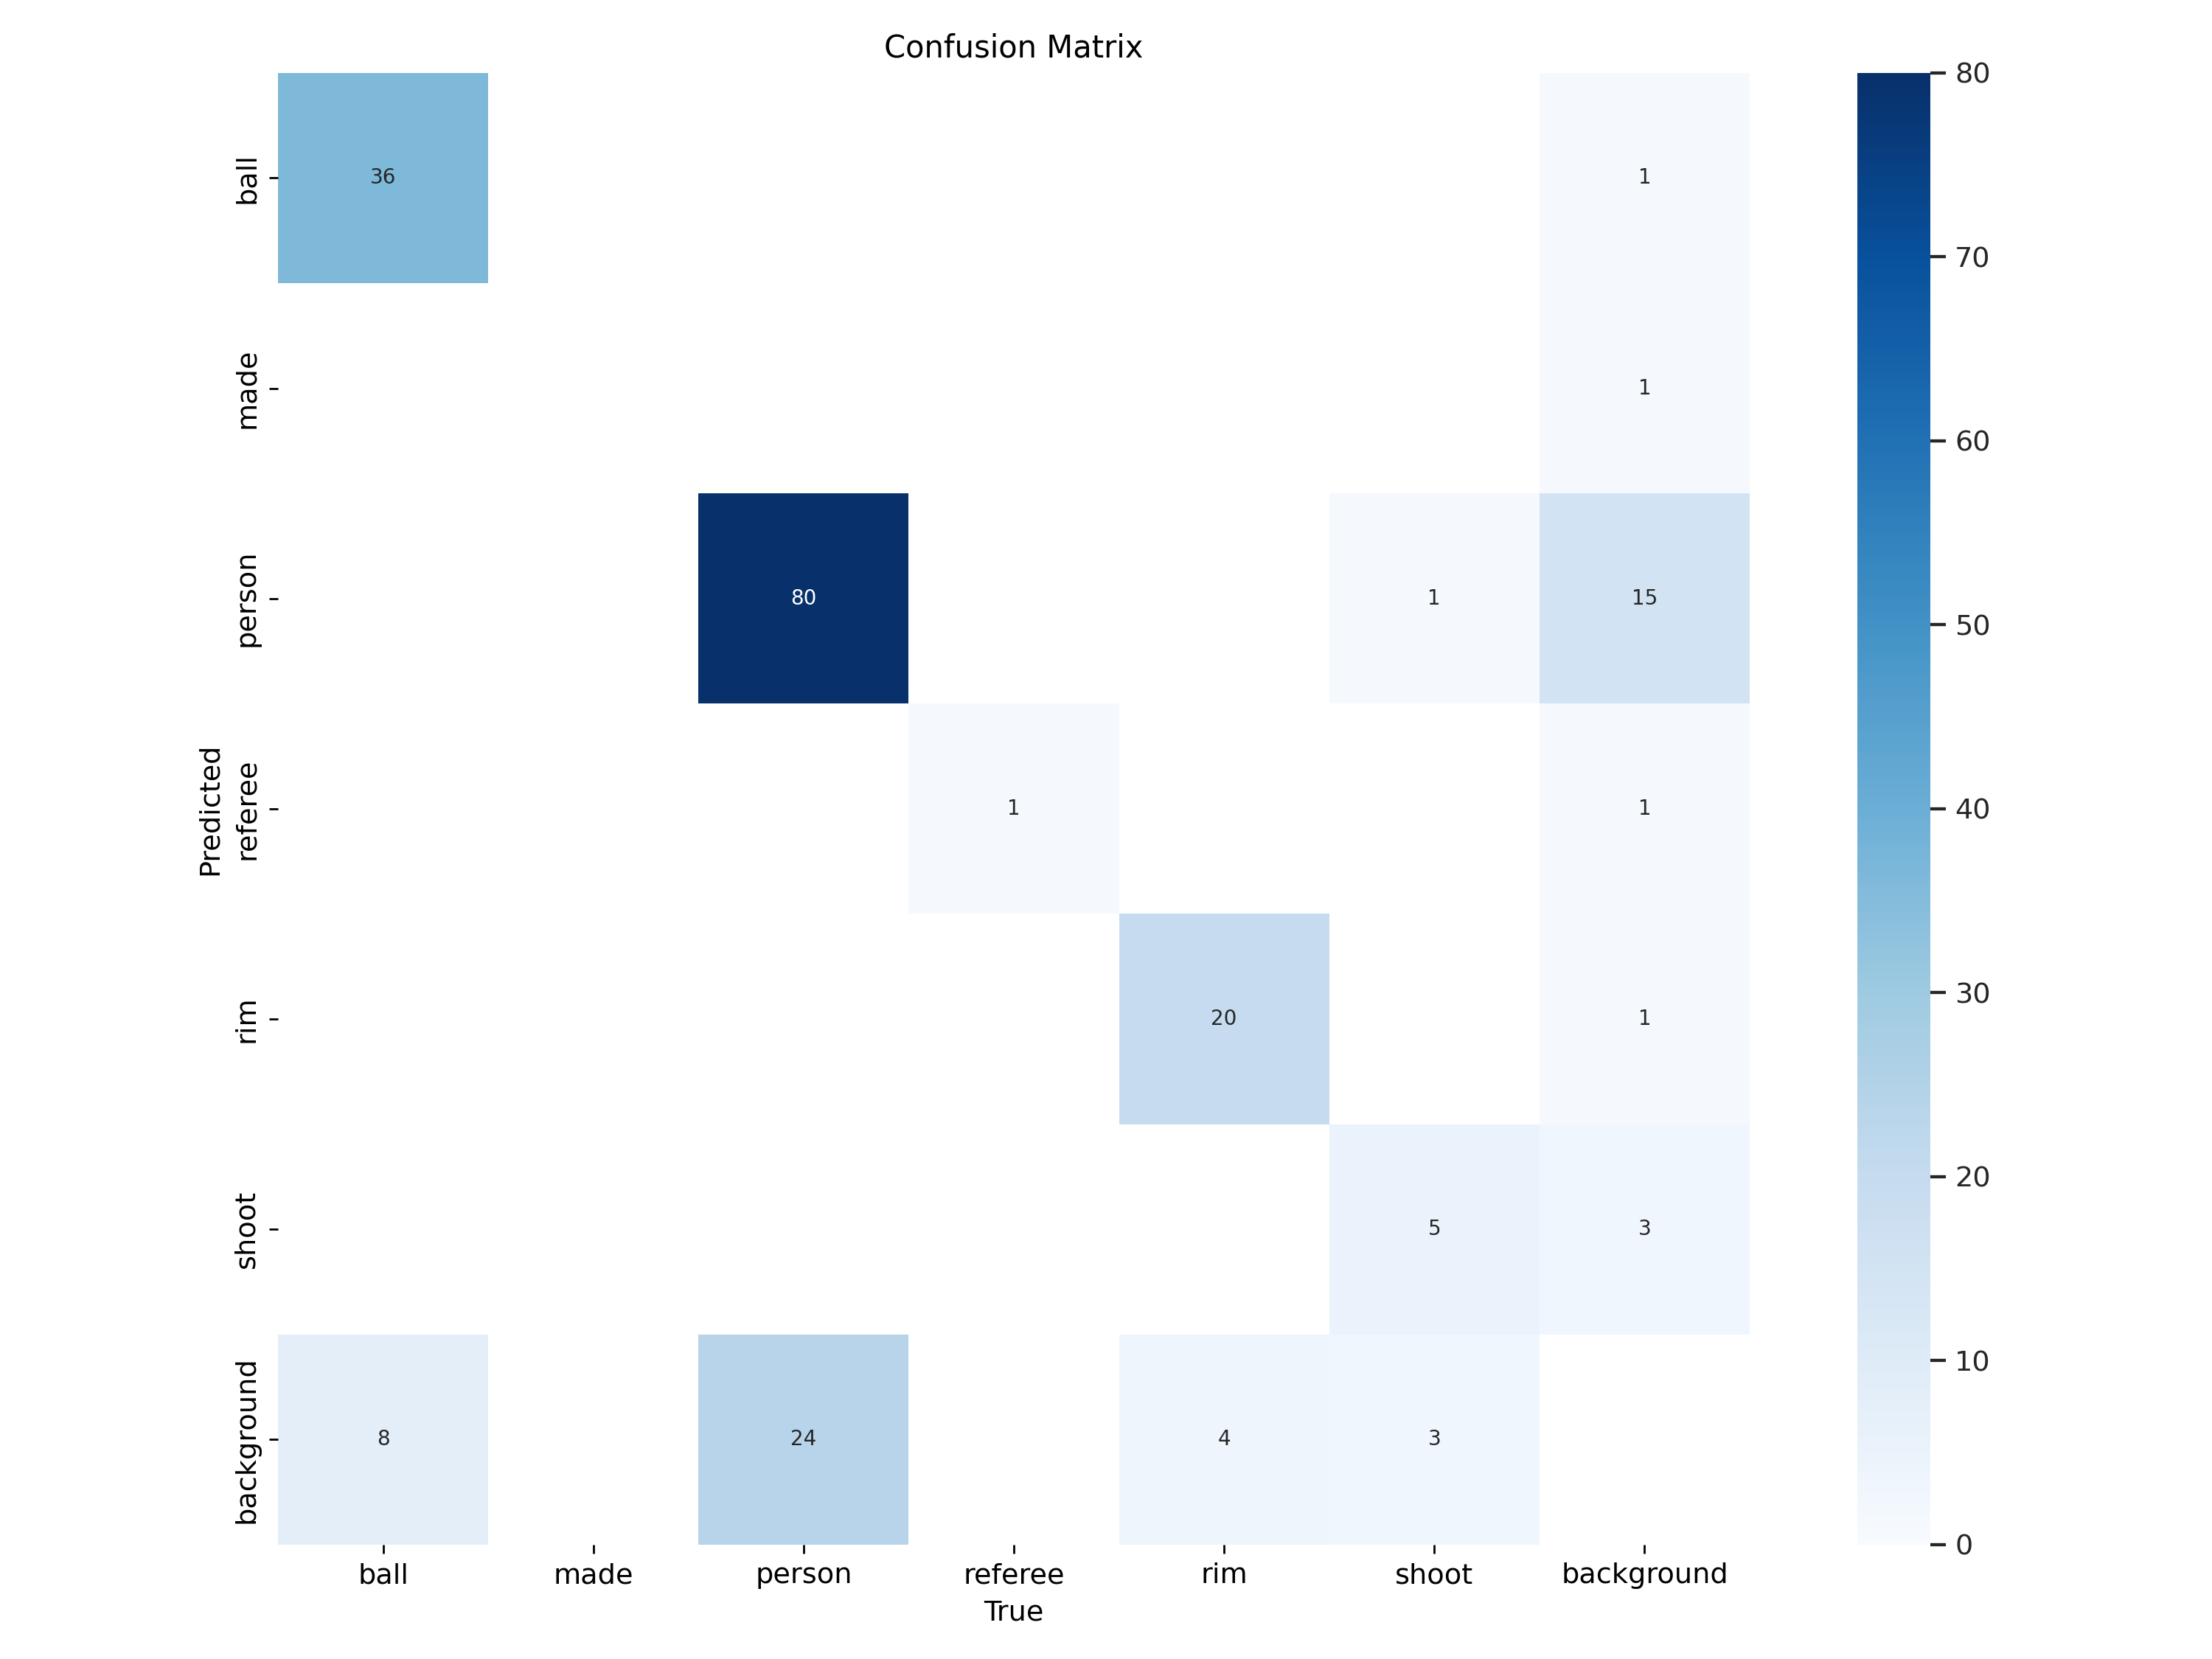

In [ ]:
Image(filename= '/content/runs/detect/train3/confusion_matrix.png' , width= 600)

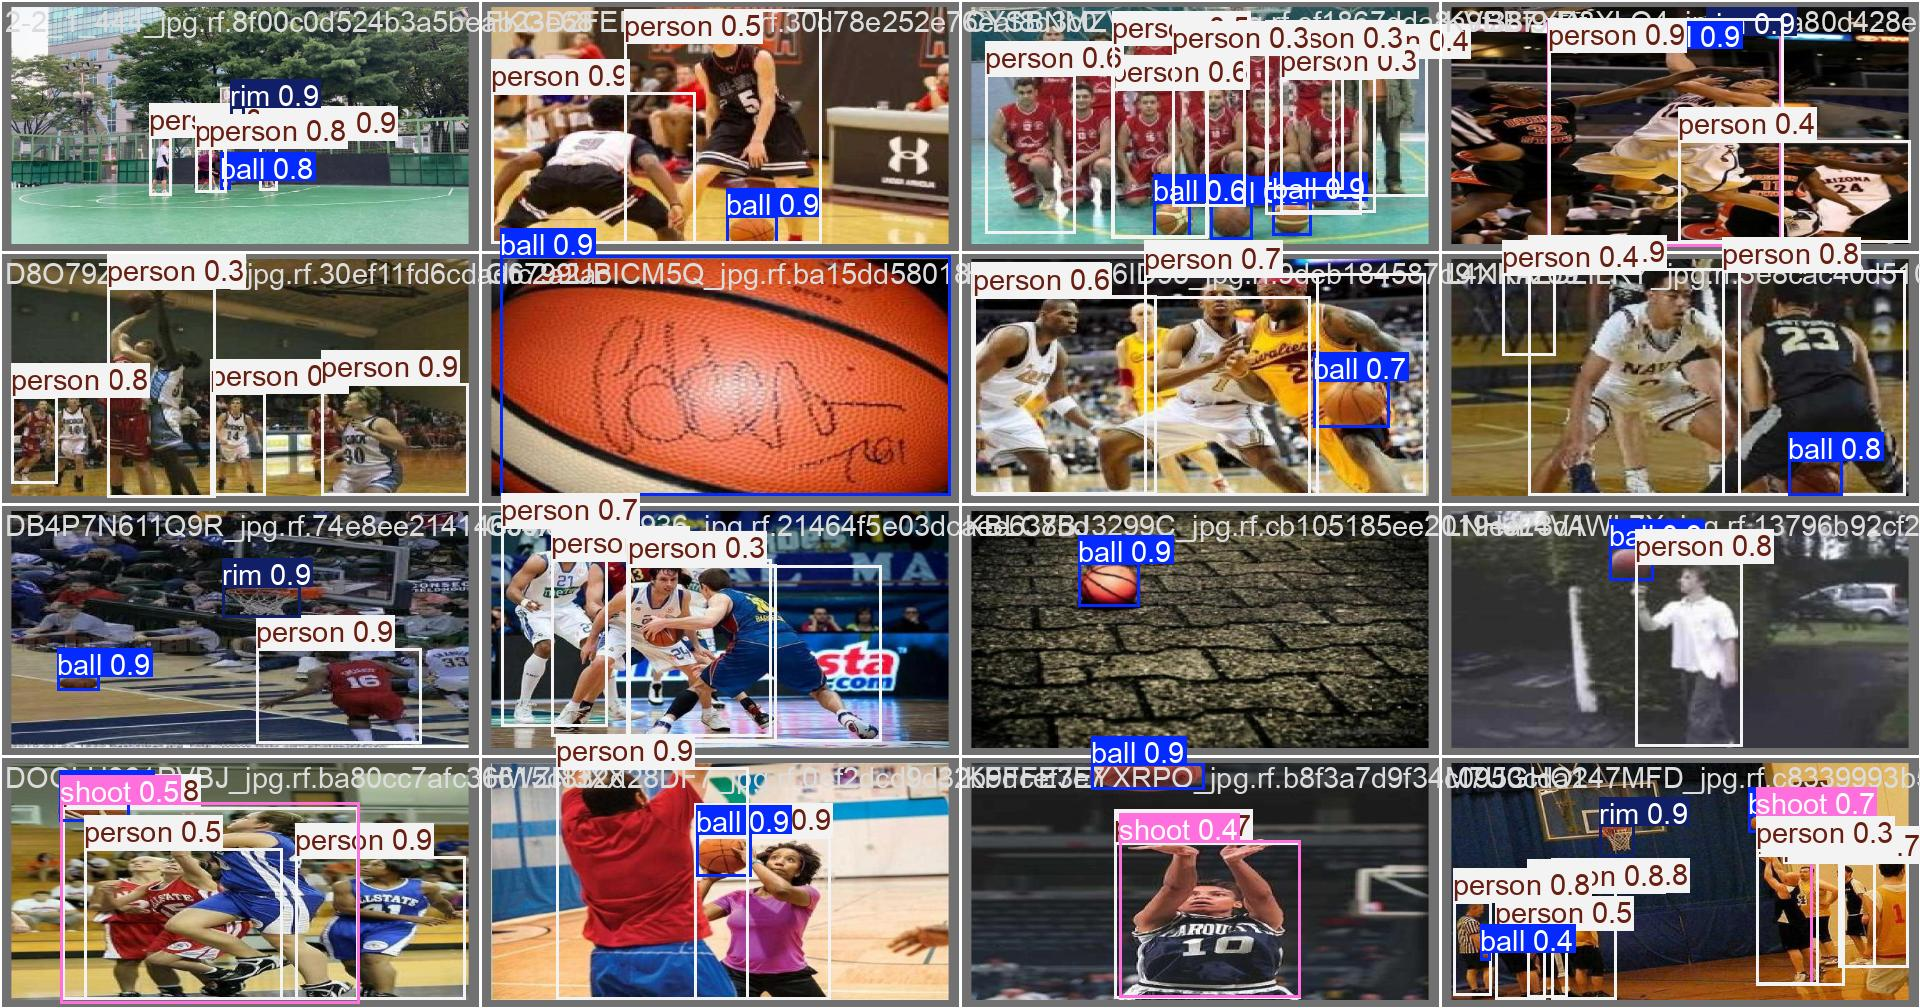

In [ ]:
Image(filename= '/content/runs/detect/train3/val_batch0_pred.jpg' , width= 900 , height = 600)

In [ ]:
!yolo task=detect mode=val model=/content/runs/detect/train3/weights/best.pt data=/content/homework-3/data.yaml

WARNING ⚠️ conflicting 'task=segment' passed with 'task=detect' model. Ignoring 'task=segment' and updating to 'task=detect' to match model.
Ultralytics 8.3.2 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11x summary (fused): 464 layers, 56,833,954 parameters, 0 gradients, 194.4 GFLOPs
val: Scanning /content/homework-3/valid/labels.cache... 40 images, 0 backgrounds, 0 corrupt: 100% 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:03<00:00,  1.04s/it]
                   all         40        182      0.857      0.817      0.893      0.629
                  ball         35         44      0.975      0.773      0.915      0.629
                person         32        104      0.872      0.702      0.839      0.526
               referee          1          1      0.603          1      0.995      0.796
                   rim         23         24      0.964      0.833        0.9      0.727
  

# Inference

In [ ]:
!pip install supervision

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.23.0


In [ ]:
MODEL = '/content/runs/detect/train3/weights/best.pt'

In [ ]:
model = YOLO(MODEL)
model.fuse()

YOLO11x summary (fused): 464 layers, 56,833,954 parameters, 0 gradients, 194.4 GFLOPs


# Predict And Annotate Single Frame

In [ ]:
CLASS_NAMES_DICT = model.model.names
CLASS_NAMES_DICT

# class_ids of interest - person, ball, rim
selected_classes = [0, 2, 4]

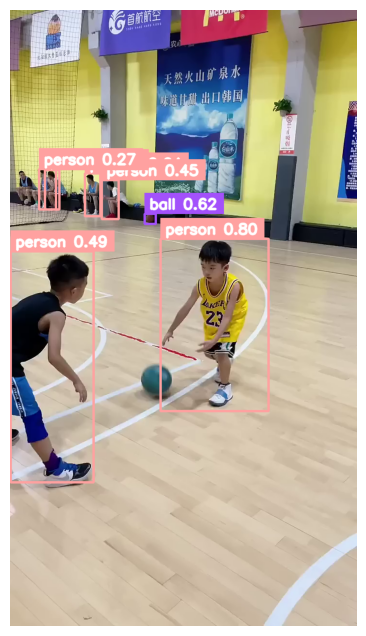

In [ ]:
import numpy as np

SOURCE_VIDEO_PATH = '/content/basketball amazing skill.mp4'
TARGET_VIDEO_PATH = f"{HOME}/basketball-result.mp4"

#Create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness= 4)
label_annotator = sv.LabelAnnotator(text_thickness= 4 , text_scale= 1)

# acquire first video frame
iterator = iter(generator)
frame = next(iterator)

# model prediction on single frame and conversion to supervision Detections
result = model(frame , verbose = False)[0]

#convert to detections
detections = sv.Detections.from_ultralytics(result)

# only consider class id from selected_classes define above
detections = detections[np.isin(detections.class_id , selected_classes)]

#custom labels
labels = [f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}" for confidence , class_id , in zip(detections.confidence , detections.class_id)]

annotated_frame = box_annotator.annotate(scene=frame , detections=detections)
annotated_frame = label_annotator.annotate(scene=frame , detections=detections, labels=labels)
%matplotlib inline
sv.plot_image(annotated_frame, (5,8))

# Predict and annotate whole video

In [ ]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=720, height=1280, fps=30, total_frames=303)

In [ ]:
# create BYTETracker instance
byte_tracker = sv.ByteTrack(frame_rate= 30 )

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create instance of BoxAnnotator & LabelAnnotator
box_annotator = sv.BoxAnnotator(thickness = 4)
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale = 1)

# create instance of TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness= 4 , trace_length= 40)

# define call back function to be used in video processing
def callback(frame:np.ndarray, index:int) -> np.ndarray:
  # model prediction on single frame and conversion to supervision Detections
  result = model(frame, verbose= False)[0]
  detections = sv.Detections.from_ultralytics(result)

  # only consider class id from selected_classes define above
  detections = detections[np.isin(detections.class_id , selected_classes) ]

  #Tracking Detections
  detections = byte_tracker.update_with_detections(detections)

  #custom labels
  labels = [f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}" for confidence , class_id , in zip(detections.confidence , detections.class_id)]

  annotated_frame = trace_annotator.annotate(scene=frame.copy(),detections=detections)
  annotated_frame = box_annotator.annotate(scene=annotated_frame , detections=detections)
  annotated_frame = label_annotator.annotate(scene=annotated_frame , detections=detections , labels=labels)

  return annotated_frame

# process the whole video
sv.process_video(
    source_path= SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)